## Main Notebook: Strategies Investigation

### Overview

This notebook analyses the exposure and performance of various strategies through two key methods.

1. **Monte Carlo Simulation**: Evaluates potential future exposure for each strategy by simulating a wide range of scenarios
2. **Percentage Growth**: Investigates the growth potential relative to the primary strategy for each alternative method.


---
### **SETUP:** Define all the programs we will use
--- 

#### **Step 1**: Import Modules
---

In [19]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import scipy
from scipy.stats import chisquare
import sys

#### **Step 2**: Defining the Strategies

Below, we outline the **Net Gross Ratio (NGR)** approach, followed by an example.

---
### NGR Approach:

- $ \text{Gross MV} = \max(0, \text{MtM}) $

- $ \text{Net MV} = \text{MtM} $

- $ \text{Current Exposure} = \text{Net MV} = \sum_i (\text{MtM}_1 + \text{MtM}_2 + \dots + \text{MtM}_n) $

- $ \text{Gross Exposure} = \sum_i \left( \max(0, \text{MtM}_1) + \max(0, \text{MtM}_2) + \dots + \max(\text{MtM}_n, 0) \right) $

- $ \text{Net Exposure} = \max\left(\sum_i (\text{MtM}_1 + \text{MtM}_2 + \dots + \text{MtM}_n), 0\right) $

- $ \text{NGR} = \frac{\text{Net Exposure}}{\text{Gross Exposure}} $
---

### Pre-Settlement Risk (PSR) Calculation:

$$
\text{PSR} = (\text{Net MV}) + \text{NGR} \times 0.6 \times (\text{AddOn\_Gross}) + 0.4 \times (\text{AddOn\_Gross})
$$
- **PSR** = MtM + AddOn, where:
    - AddOn = AddOn × AddOn Factor


---

### Example:

Given the following values:
- **p** = [10, 20]
- **x₁** = [-5, 10]
- **x₂** = [10, 30]
- **addOnFactor** = 0.01

#### Step-by-Step Calculations:

1. **Current Exposure**:  
   Current Exposure = 10 - 5 + 10 = **15**

2. **Net Gross Ratio (NGR)**:  
   - **Gross Exposure (GE)** = 10 + 0 + 10 = **20**  
   - **Net Exposure (NE)** = max(10 - 5 + 10, 0) = **15**  
   - **NGR** = NE / GE = 15 / 20 = **0.75**

3. **AddOn Gross**:  
   AddOn_Gross = 0.01 × 20 + 0.01 × 10 + 0.01 × 30 = **0.6**

4. **PSR Calculation**:
   $$
   \text{PSR} = 15 + (0.75 \times 0.6 \times 0.6) + (0.4 \times 0.6) = 15.51
   $$

5. **Normal PSR Calculation**:  
   Normal PSR = 15 + 0.01 × (20 + 10 + 30) = **15.6**

   Thus, **PSR** is reduced by the NGR method (incorporating netting).

---

**Note**:  
We define the **NGR algorithm**, following the Basel I recommendations for calculating Pre-Settlement Risk. The Brute Force method does not have a separate function since it only passes through the `PSR_NGR()` function once. Alternative strategies call `PSR_NGR` multiple times due to decoupling.


In [20]:
def PSR_NGR(positions, addOnFactor, singleposition):

    GrossExposure = 0
    CurrentExposure = 0
    NetExposure = 0
    AddOn_Gross = 0

    # This if statement recognises if a single position is being passed in the argument.
    # If so, it needs to handled differently. (For conservative method and calculating baseline)
    
    if singleposition == True:
        GrossExposure += max(0, positions[0])
        CurrentExposure += positions[0]
        AddOn_Gross += addOnFactor * positions[1]
    else:
        for i in range(len(positions)):
            GrossExposure += max(0, positions[i,0])
            CurrentExposure += positions[i,0]
            AddOn_Gross += addOnFactor * positions[i,1]

    NetExposure = max(0, CurrentExposure)

    if GrossExposure == 0:
        NGR = 0
    else:
        NGR = NetExposure/GrossExposure
    
    PSR = max(0, CurrentExposure) + NGR * (0.6) * (AddOn_Gross) + (0.4) * (AddOn_Gross)

    return PSR


# Conservative Approach: This algorithm decouples each position and calculates exposure in individual components
def PSR_Conservative(positions, addOnFactor):

    total_PSR_NGR = 0
    singleposition = True

    for i in range(len(positions)):
        total_PSR_NGR += PSR_NGR(positions[i,:], addOnFactor, singleposition)
    
    return total_PSR_NGR

# Linearisation Approach: This approach decouples each position and calculates the "difference" between a
# new position and the baseline
def PSR_Linear(positions, addOnFactor):

    total_PSR_NGR = 0

    base_PSR_NGR = 0
    singleposition = True
    sample = positions[0,:]
    base_PSR_NGR += PSR_NGR(sample, addOnFactor, singleposition)
    total_PSR_NGR = base_PSR_NGR

    singleposition = False

    for i in range(len(positions)-1):
        total_PSR_NGR += (PSR_NGR(positions[[0,i+1], :], addOnFactor, singleposition) - base_PSR_NGR)

    return total_PSR_NGR

# Average Approach: This approach is similar to the linearisation approach, only that we now multiply
# our original position by the number of impacts and divide by the same number
def PSR_Average(positions, addOnFactor, n):

    total_PSR_NGR = 0
    base_PSR_NGR = 0

    singleposition = True
    base_PSR_NGR += PSR_NGR(positions[0,:], addOnFactor, singleposition)
    total_PSR_NGR = base_PSR_NGR

    singleposition = False

    for i in range(len(positions)-1):

        # take out the baseline position and the x_i position
        trade_i = positions[[0,i+1], :]
        
        # multiply the i-th position by n - as it happens in the formula
        trade_i[1,:] *= n

        # multiply the formula by n
        total_PSR_NGR += 1/n*(PSR_NGR(trade_i, addOnFactor, singleposition) - base_PSR_NGR)


    return total_PSR_NGR

#### **Sample Datasets for Testing Purposes**

In [21]:
# TEST 1: PSR_NGR = 30.765 , PSR_BruteForce = 30.9
'''    
positions = np.zeros((4,2))

positions[0,0] = 10
positions[1,0] = 20
positions[2,0] = -10
positions[3,0] = 10


positions[0,1] = 20
positions[1,1] = 40
positions[2,1] = 10
positions[3,1] = 20
'''


# TEST 1: PSR_NGR = 30.765 , PSR_BruteForce = 30.9
'''    
positions = np.zeros((4,2))

positions[0,0] = 10
positions[1,0] = 20
positions[2,0] = -10
positions[3,0] = 10


positions[0,1] = 20
positions[1,1] = 40
positions[2,1] = 10
positions[3,1] = 20
'''

# Randomly generated set of [MTM, Notional]
    # TEST 1A
'''
positions = np.zeros((2,2))

positions[0,0] = 10
positions[1,0] = 20

positions[0,1] = 20
positions[1,1] = 40
'''

# TEST 2: PSR_NGR = 15.51 , PSR_BruteForce = 15.6

'''
positions = np.zeros((3,2))

positions[0,0] = 10
positions[1,0] = -5
positions[2,0] = 10

positions[0,1] = 20
positions[1,1] = 10
positions[2,1] = 30
'''

'\npositions = np.zeros((3,2))\n\npositions[0,0] = 10\npositions[1,0] = -5\npositions[2,0] = 10\n\npositions[0,1] = 20\npositions[1,1] = 10\npositions[2,1] = 30\n'

#### **Step 3:** Define our main program for Monte Carlo Simulation
---

In [22]:
def main(n, baseline_mtm):

    # Randomly generated set of [MTM, Notional]
    positions = np.zeros((n, 2))

    positions[0, 0] = baseline_mtm
    positions[0, 1] = 1000

    for i in range(len(positions) - 1):
        positions[i + 1, 0] = random.randint(-10, 10)
        positions[i + 1, 1] = abs(5 * positions[i, 0])

    addOnFactor = 0.01
    singleposition = False

    # Initialize cumulative PSR values and lists
    cumulative_positions = np.zeros((0, 2))  # empty to start
    bf_list = []
    lin_list = []
    cons_list = []
    avg_list = []

    for j in range(len(positions)):

        # Add the next position to the cumulative set
        cumulative_positions = np.vstack([cumulative_positions, positions[j, :]])

        # Perform the PSR calculations for each strategy
        NGR_BF = PSR_NGR(cumulative_positions, addOnFactor, singleposition)
        NGR_Lin = PSR_Linear(cumulative_positions, addOnFactor)
        NGR_Cons = PSR_Conservative(cumulative_positions, addOnFactor)
        NGR_Avg = PSR_Average(cumulative_positions, addOnFactor, j + 1)

        # Append results to respective lists
        bf_list.append(NGR_BF)
        lin_list.append(NGR_Lin)
        cons_list.append(NGR_Cons)
        avg_list.append(NGR_Avg)
    
    print(positions)
    print("BF: ", bf_list)
    print("Lin: ", lin_list)
    print("Cons: ", cons_list)
    print("Avg: ", avg_list)

    # Check final PSR values for the full positions matrix
    final_BF = PSR_NGR(positions, addOnFactor, singleposition)
    final_Lin = PSR_Linear(positions, addOnFactor)
    final_Cons = PSR_Conservative(positions, addOnFactor)
    final_Avg = PSR_Average(positions, addOnFactor, len(positions))

    # Print these values
    print("\nFinal PSR NGR for Brute Force: ", final_BF)
    print("\nFinal PSR NGR for Linearisation: ", final_Lin)
    print("\nFinal PSR NGR for Conservative: ", final_Cons)
    print("\nFinal PSR NGR for Averages: ", final_Avg)

    return [positions, addOnFactor, bf_list, lin_list, cons_list, avg_list]


# Run the simulation
[positions, addOnFactor, bf_list, lin_list, cons_list, avg_list] = main(100, 100)



[[ 100. 1000.]
 [  -7.  500.]
 [  -6.   35.]
 [   6.   30.]
 [   0.   30.]
 [  -6.    0.]
 [   2.   30.]
 [   2.   10.]
 [   5.   10.]
 [  -3.   25.]
 [   3.   15.]
 [   5.   15.]
 [  -1.   25.]
 [  -4.    5.]
 [   3.   20.]
 [  10.   15.]
 [  10.   50.]
 [   1.   50.]
 [  -9.    5.]
 [   0.   45.]
 [  -2.    0.]
 [  10.   10.]
 [   5.   50.]
 [   5.   25.]
 [ -10.   25.]
 [   6.   50.]
 [  -9.   30.]
 [   5.   45.]
 [   5.   25.]
 [   6.   25.]
 [ -10.   30.]
 [   4.   50.]
 [   6.   20.]
 [   5.   30.]
 [   2.   25.]
 [  -6.   10.]
 [ -10.   30.]
 [  10.   50.]
 [  -4.   50.]
 [   8.   20.]
 [  -1.   40.]
 [  -8.    5.]
 [  -3.   40.]
 [   7.   15.]
 [ -10.   35.]
 [   3.   50.]
 [   5.   15.]
 [  -6.   25.]
 [   9.   30.]
 [   9.   45.]
 [   1.   45.]
 [   6.    5.]
 [   7.   30.]
 [  -7.   35.]
 [   4.   35.]
 [   1.   20.]
 [   8.    5.]
 [  -5.   40.]
 [  -8.   25.]
 [   7.   40.]
 [  -7.   35.]
 [  -1.   35.]
 [   9.    5.]
 [   2.   45.]
 [ -10.   10.]
 [  -3.   50.]
 [  -3.   

#### **NB:** Set up Baseline Position and Incoming Trades 

In [23]:
# BASELINE POSITION
MarkToMarket = 100
Notional = 1000


# For the incoming positions , we simply set the range of the values used for sampling incoming trades
MTM_Min = -10
MTM_Max = 10


# For simplicity, we set the AddOnFactor to be the same for all the trades
addOnFactor = 0.01

#### **Step 5:** Generate the dataset: Baseline Position + Incoming Trades

In [24]:
# This function generates our dataset which we will act upon.
# Note: Our first row will be our baseline position, the rest will
# be our incoming impacts.

def get_position_impacts(n, MarkToMarket, Notional, MTM_Min, MTM_Max):
    
    baseline_position = [MarkToMarket, Notional]
    mtm_notional_matrix = np.zeros((n,2))

    
    for i in range(n):

        mtm_notional_matrix[i,0] = random.randint(MTM_Min,MTM_Max)
        mtm_notional_matrix[i,1] = abs(mtm_notional_matrix[i,0])*10
        
        
    positions = np.vstack([baseline_position, mtm_notional_matrix])
    return positions

#### **Step 6:** Calculate Mean and Variance of the respective methods

In [25]:
def get_mean_variance(final_vals, samples):
    
    mu = []
    sigma = []
    std = []

    for i in range(final_vals.shape[0]):
        mu.append(np.sum(final_vals[i,:])/samples)

        current_mu = np.sum(final_vals[i,:])/samples

        std.append(np.std(final_vals[i,:]))

        diff_squared = np.sum((final_vals[i,:] - current_mu) ** 2)
        sigma.append(diff_squared / samples)
        
    return [mu,sigma, std]

#### **Step 6a:** Clean data (by rounding float numbers to 4 decimal places)

In [26]:
def remove_decimal_places(my_list):
    new_list = list(np.around(np.array(my_list), 4))
    return new_list

## **PART 1:** Monte Carlo Simulation of the Strategies (PFE)

In this section, we conduct a Monte Carlo simulation to *analyze the distribution of exposure strategies.*

We generate a random dataset, comprising baseline data and positions, and input this into each exposure calculator. This process is repeated multiple times to obtain a comprehensive distribution of results.


#### **Step 7:** Simluate the exposure calculations via. the following function

In [27]:
def exposure_simulation1(n, samples, addOnFactor, MarkToMarket, Notional, MTM_Min, MTM_Max):

    # POST-PROCESSING: Define the plots that we will use to graph results
    x = np.linspace(0,n+1,n+1)
    final_vals = np.zeros((4,samples))

    fig,axs = plt.subplots(2,2, figsize=(10,8))
    fig.subplots_adjust(hspace=0.5) 
    fig.subplots_adjust(wspace=0.5) 

    singleposition = False
    
    # This for loop generates a random dataset, collects the output after passing it through each strategy function,
    # and the output gets plotted on the graphs 
    for i in range(samples):

    # Initialize cumulative PSR values and lists
        positions = get_position_impacts(n, MarkToMarket, Notional, MTM_Min, MTM_Max)
        cumulative_positions = np.zeros((0, 2))  # empty to start
        bf_list = []
        lin_list = []
        cons_list = []
        avg_list = []

        for j in range(len(positions)):

            # Add the next position to the cumulative set
            cumulative_positions = np.vstack([cumulative_positions, positions[j, :]])

            # Perform the PSR calculations for each strategy
            NGR_BF = PSR_NGR(cumulative_positions, addOnFactor, singleposition)
            NGR_Lin = PSR_Linear(cumulative_positions, addOnFactor)
            NGR_Cons = PSR_Conservative(cumulative_positions, addOnFactor)
            NGR_Avg = PSR_Average(cumulative_positions, addOnFactor, n)

            # Append results to respective lists
            bf_list.append(NGR_BF)
            lin_list.append(NGR_Lin)
            cons_list.append(NGR_Cons)
            avg_list.append(NGR_Avg)
        
        axs[0,0].plot(x,bf_list, c='b', label="Brute Force")
        axs[0,1].plot(x,lin_list, 'g', label="Linearisation")
        axs[1,0].plot(x,cons_list, 'r', label="Conservative")
        axs[1,1].plot(x,avg_list, 'y', label="Averages")
        

        final_vals[0,i] = bf_list[-1]
        final_vals[1,i] = lin_list[-1]
        final_vals[2,i] = cons_list[-1]
        final_vals[3,i] = avg_list[-1]


    # Label each plot
    axs[0,0].set_xlabel("Trade Number")
    axs[0,0].set_ylabel("Exposure")

    axs[1,0].set_xlabel("Trade Number")
    axs[1,0].set_ylabel("Exposure")

    axs[0,1].set_xlabel("Trade Number")
    axs[0,1].set_ylabel("Exposure")

    axs[1,1].set_xlabel("Trade Number")
    axs[1,1].set_ylabel("Exposure")
    
    axs[0,0].set_title("Brute Force")
    axs[0,1].set_title("Linearisation")
    axs[1,0].set_title("Conservative")
    axs[1,1].set_title("Averages")

    plt.show()
    
    '''
    if widget == False:
        return final_vals
    else:
        return None    
    '''
    return final_vals


#### **Step 8:** Run the functions above, analyse the graphs, and inspect mean and variance of each method

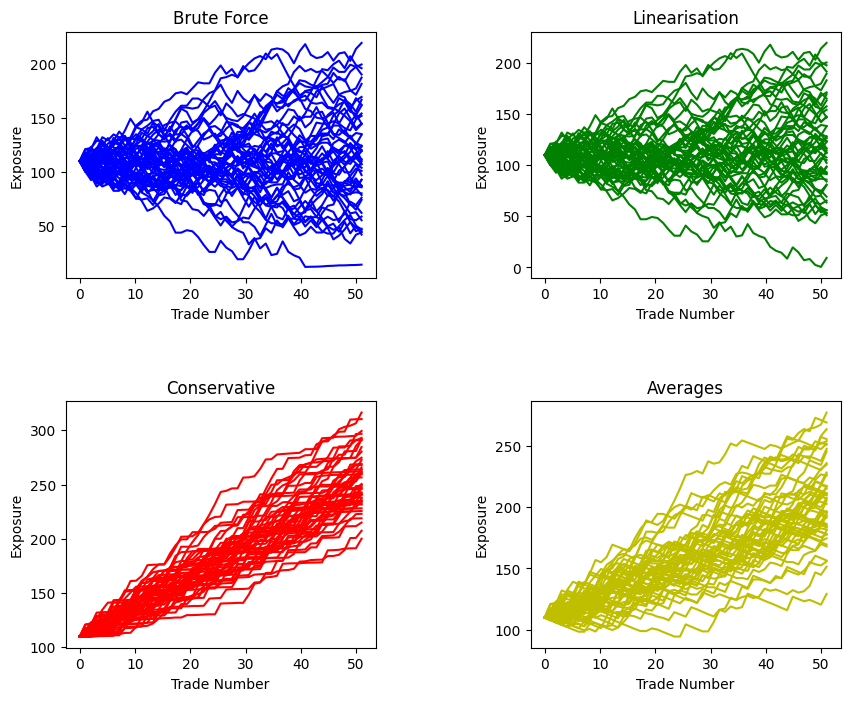

Entries below will correspond as follows : [Brute Force, Linearisation, Conservative, Averages]
Average Values at trade 100:  [113.5673, 117.9023, 254.5028, 205.6246]
Variance at trade 100:  [2205.3351, 2085.0243, 690.4007, 1049.359]
Standard Deviation at trade 100:  [46.961, 45.6621, 26.2755, 32.3938]


In [28]:
samples = 50
n = 50
addOnFactor = 0.01

final_vals = exposure_simulation1(n, samples, addOnFactor, MarkToMarket, Notional, MTM_Min, MTM_Max)

[mu,sigma,std] = get_mean_variance(final_vals, samples)


print("Entries below will correspond as follows : [Brute Force, Linearisation, Conservative, Averages]")
print("Average Values at trade 100: ", remove_decimal_places(mu))
print("Variance at trade 100: ", remove_decimal_places(sigma))
print("Standard Deviation at trade 100: ", remove_decimal_places(std))

### **INTERACTIVE GRAPH**
##### Toggle the sliders below to investigate the growth rates!

In [29]:
# Define your sliders
n_slider = widgets.IntSlider(min=20, max=400, step=1, value=50, description="No. of Trades")
samples_slider = widgets.IntSlider(min=0, max=500, step=20, value=50, description="No. of Samples")
addOnFactor_slider = widgets.FloatSlider(min=0, max=1, value=0.01, step=0.01, description="addOnFactor")
MarkToMarket_slider = widgets.IntSlider(min=0, max=10000, step=100, value=1000, description="Base MTM")
Notional_slider = widgets.IntSlider(min=0, max=1000000, step=1000, value=100000, description="Base Notional")
MTM_Min_slider = widgets.IntSlider(min=-1000, max=-100, step=10, value=-10, description="MTM Min")
MTM_Max_slider = widgets.IntSlider(min=100, max=1000, step=10, value=10, description="MTM Max")

# Function to update slider values based on button press
def set_preset_1(b):
    n_slider.value = 50
    samples_slider.value = 50
    addOnFactor_slider.value = 0.01
    MarkToMarket_slider.value = 5000
    Notional_slider.value = 500000
    MTM_Min_slider.value = -500
    MTM_Max_slider.value = 500

def set_preset_2(b):
    n_slider.value = 50
    samples_slider.value = 50
    addOnFactor_slider.value = 0.01
    MarkToMarket_slider.value = 10000
    Notional_slider.value = 1000000
    MTM_Min_slider.value = -100
    MTM_Max_slider.value = 100

# Create buttons for presets
preset_button_1 = widgets.Button(description="Low Baseline + High Impacts")
preset_button_2 = widgets.Button(description="High Baseline + Low Impacts")

# Assign button click event to set preset values
preset_button_1.on_click(set_preset_1)
preset_button_2.on_click(set_preset_2)

# Make the buttons larger
preset_button_1.layout = Layout(width='250px', height='50px')
preset_button_2.layout = Layout(width='250px', height='50px')

# Create a grid layout for the sliders (2x3 layout)
grid_layout = widgets.GridBox(
    children=[n_slider, samples_slider, MarkToMarket_slider, addOnFactor_slider, Notional_slider, MTM_Min_slider, MTM_Max_slider],
    layout=Layout(grid_template_columns="repeat(3, 300px)", grid_template_rows="repeat(3, auto)", grid_gap="10px")
)

# Layout for buttons
button_layout = widgets.HBox([preset_button_1, preset_button_2])

# Display the interactive widgets and buttons in a grid layout
ui = widgets.VBox([grid_layout, button_layout])
out = widgets.interactive_output(exposure_simulation1, {
    'n': n_slider, 
    'samples': samples_slider, 
    'addOnFactor': addOnFactor_slider, 
    'MarkToMarket': MarkToMarket_slider, 
    'Notional': Notional_slider, 
    'MTM_Min': MTM_Min_slider, 
    'MTM_Max': MTM_Max_slider
})

display(ui, out)

# NOT WORKING RIGHT : THE AVERAGES SHOULD BE THE SAME AS CONSERVATIVE -- INVESTIGATE

Output()

In [30]:
'''widgets.interact(exposure_simulation1, 
         n = widgets.IntSlider(min = 20 , max = 400, step = 1, value=100, description="No. of Trades"),
         samples = widgets.IntSlider(min=0,max=500,step=20,value=200,description="No. of Samples"),
         addOnFactor = widgets.FloatSlider(min=0, max = 1, value=0.01, step = 0.01, description="addOnFactor"),
         MarkToMarket = widgets.IntSlider(min=0,max=10000,step=100,value=1000,description="Base MTM"),
         Notional = widgets.IntSlider(min=0,max=1000000,step=1000,value=100000,description="Base Notional"),
         MTM_Min = widgets.IntSlider(min=-1000,max=-100,step=10,value=-10,description="MTM Min"),
         MTM_Max = widgets.IntSlider(min=100,max=1000,step=10,value=10,description="MTM Max"), 
)'''

'widgets.interact(exposure_simulation1, \n         n = widgets.IntSlider(min = 20 , max = 400, step = 1, value=100, description="No. of Trades"),\n         samples = widgets.IntSlider(min=0,max=500,step=20,value=200,description="No. of Samples"),\n         addOnFactor = widgets.FloatSlider(min=0, max = 1, value=0.01, step = 0.01, description="addOnFactor"),\n         MarkToMarket = widgets.IntSlider(min=0,max=10000,step=100,value=1000,description="Base MTM"),\n         Notional = widgets.IntSlider(min=0,max=1000000,step=1000,value=100000,description="Base Notional"),\n         MTM_Min = widgets.IntSlider(min=-1000,max=-100,step=10,value=-10,description="MTM Min"),\n         MTM_Max = widgets.IntSlider(min=100,max=1000,step=10,value=10,description="MTM Max"), \n)'

#### **Step 8a:** We can show that the conservative approach follows Arithmetic Brownian Motion (ABM). All we need to do is calculate the mean and standard deviation of Y = max(0,X) + 0.1*abs(X) and implement the formula for ABM

Mean of distribution: 2.9988825428618027  Standard Deviation of distribution: 3.352219755439138


mu =  2.9988825428618027
sigma =  3.352219755439138
Distribution of trades at trade 100 --> N( mu * t + X_0 , sigma^2 * t ) = N( 259.9441271430901 , 561.8688644378218 )


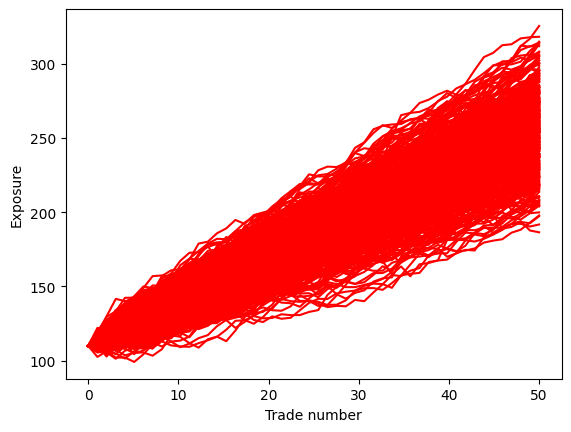

In [31]:

np.random.seed(2020)

X = np.random.uniform(MTM_Min,MTM_Max,10**5)

Y = [max(0,i) + addOnFactor * 10 * abs(i) for i in X]

# This monte carlo simluates the mean and variance, but maybe also show how it's done by hand as well !

mu = np.mean(Y)
standard_dev = np.std(Y)

dt = 1

print("Mean of distribution: " + str(mu) + "  Standard Deviation of distribution: " + str(standard_dev))
print("\n")
T = n  # T = Time <=> Trade 

m = int(T/dt)
t = np.linspace(0,T,m)

def run_sim():

    x = np.zeros(m)
    x[0] = MarkToMarket + 0.01 * Notional

    for i in range(m-1):
        # This is our ABM equation. There are more stochastic calculus notes on the paper. 
        x[i+1] = x[i] + mu*dt + standard_dev*np.random.normal(0,1)*np.sqrt(dt)
    
    return x

plt.figure()
for i in range(500):
    x = run_sim()

    plt.plot(t, x, 'r')


print("mu = ", mu)
print("sigma = ", standard_dev)
mu_T = mu*T
sigma_T = standard_dev ** 2 * T
print("Distribution of trades at trade 100 --> N( mu * t + X_0 , sigma^2 * t ) = N( " + str(mu*T + x[0]) + " , " + str(standard_dev ** 2 * T) + " )")
plt.xlabel("Trade number")
plt.ylabel("Exposure")
plt.show()



## **Part 2:** Percentage Growth Relative to the Brute Force Method

In this section, we explore the extent to which alternative strategies overestimate exposure.

The code below investigates the growth through an interactive graph, allowing you to visualize how the strategies perform across different positions.


#### **OPTIONAL:** Perform a data clean to remove outliers in the percentage growth. 
Often when the trdae number is small, the rate of growth can be exponential, so we can remove them using the function below 

In [32]:
def remove_outliers(data, threshold = 2):

    # The growth in exposure from the baseline can be exceptionally high for a small number of trades (since we are going from 0% difference to, for instance, a 20% differnce depending on the impacts we use).
    # This function removes the outliers that impact our analysis of the graph, by using standard mean and variance approaches

    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data)
    cleaned_data = data.copy()

    for i in range(len(data)):

        if -(mean+threshold*std_dev) < data[i] < (mean+threshold*std_dev):
            cleaned_data[i] = data[i]
        else:
            if i == 0:
                neighbors = [data[j] for j in range(max(0, i+5), min(len(data), i+3)) if j != i]
                cleaned_data[i] = np.median(neighbors)
            elif i == len(data) - 1:
                continue
            else:
                # Method: use median and neighbours
                neighbors = [data[j] for j in range(max(0, i-2), min(len(data), i+3)) if j != i]
                cleaned_data[i] = np.median(neighbors)
    return cleaned_data
    

#### **Step 9:** Run the code below to simluate percentage growth

The way we will investigate percentage growth is as follows
1. We generate a random dataset for a given number of trades (we start with i = small number)
2. This dataset gets passed throught the exposure calculator functions (Brute Force, Linearisation, Conservative, Averages)
3. We calculate the **percentage difference between the alternative approaches and the brure force approach**
4. We store these values in a list
5. We increase the number of trades (i += 1)
6. We repeat steps 1-5 until we reach our max number (we define n = arbitrary large number)
7. We plot our lists on a graph and analyse how the percentage difference varies for different parameters

In [33]:
# What we will do is the following:


def simulation_exposure_growth(n, addOnFactor, MarkToMarket, Notional, MTM_Min, MTM_Max, lin=True, cons=False, avg=False, dataclean=False):
    
    bf_exposure_for_trade_i = []
    cons_exposure_for_trade_i = []
    lin_exposure_for_trade_i = []
    avg_exposure_for_trade_i = []

    # We calculate the exposure for each value of i (1 to n) on a randomly generated dataset and calculate the percentage difference
    for i in range(1,n):
        
        bf_list = []
        cons_list = []
        lin_list = []
        avg_list = []

        positions = get_position_impacts(i, MarkToMarket, Notional, MTM_Min, MTM_Max)
        
        singleposition = False

        NGR_BF = PSR_NGR(positions, addOnFactor, singleposition)
        NGR_Lin = PSR_Linear(positions, addOnFactor)
        NGR_Cons = PSR_Conservative(positions, addOnFactor)
        NGR_Avg = PSR_Average(positions, addOnFactor, n)


        bf_exposure_for_trade_i.append(NGR_BF)
        cons_exposure_for_trade_i.append(NGR_Cons)
        lin_exposure_for_trade_i.append(NGR_Lin)
        avg_exposure_for_trade_i.append(NGR_Avg)


    diff_cons = [(cons_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
    diff_lin = [(lin_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
    diff_avg = [(avg_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
    
    # OPTIONAL: We can remove any outliers from the dataset.
    if dataclean == True:
        diff_cons = remove_outliers(diff_cons, 3)
        diff_lin = remove_outliers(diff_lin, 3)
        diff_avg = remove_outliers(diff_avg, 3)


    # We plot our results below
    x = np.arange(1,n)

    plt.figure(figsize=(8, 5))
    plt.grid(True)

    if lin == True:
        plt.plot(x[int(n/100):],diff_lin[int(n/100):],'g', label="Linearisation")
    
    if cons == True:
        plt.plot(x,diff_cons,'r', label="Conservative")

    if avg == True:
        plt.plot(x,diff_avg,'y', label="Averages")

    plt.xlabel("# of trades")
    plt.ylabel("% Diff. from Brute Force")
    plt.legend()
    plt.show()

        

In [34]:
'''widgets.interact(simulation_exposure_growth,
         n = widgets.IntSlider(min = 20 , max = 500, step = 5, value = 100, description="No. Trades"),
         addOnFactor = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.01,description="AddOnFactor"),
         MarkToMarket = widgets.IntSlider(min=0,max=100000,step=100,value=1000,description="Base MTM"),
         Notional = widgets.IntSlider(min=0,max=1000000,step=1000,value=100000,description="Base Notional"),
         MTM_Min = widgets.IntSlider(min=-10000,max=-100,step=10,value=-10,description="MTM Min"),
         MTM_Max = widgets.IntSlider(min=100,max=10000,step=10,value=10,description="MTM Max"),
)'''

'widgets.interact(simulation_exposure_growth,\n         n = widgets.IntSlider(min = 20 , max = 500, step = 5, value = 100, description="No. Trades"),\n         addOnFactor = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.01,description="AddOnFactor"),\n         MarkToMarket = widgets.IntSlider(min=0,max=100000,step=100,value=1000,description="Base MTM"),\n         Notional = widgets.IntSlider(min=0,max=1000000,step=1000,value=100000,description="Base Notional"),\n         MTM_Min = widgets.IntSlider(min=-10000,max=-100,step=10,value=-10,description="MTM Min"),\n         MTM_Max = widgets.IntSlider(min=100,max=10000,step=10,value=10,description="MTM Max"),\n)'

#### **Step 10:** Run the code using the interactive graph below

In [35]:
'''widgets.interact(simulation_exposure_growth,
         n = widgets.Play(min = 20 , max = 500, step = 20, interval=200),
         addOnFactor = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.01,description="AddOnFactor"),
         MarkToMarket = widgets.IntSlider(min=0,max=10000,step=100,value=1000,description="Base MTM"),
         Notional = widgets.IntSlider(min=0,max=1000000,step=1000,value=100000,description="Base Notional"),
         MTM_Min = widgets.IntSlider(min=-1000,max=-100,step=10,value=-10,description="MTM Min"),
         MTM_Max = widgets.IntSlider(min=100,max=1000,step=10,value=10,description="MTM Max"),
)'''

'widgets.interact(simulation_exposure_growth,\n         n = widgets.Play(min = 20 , max = 500, step = 20, interval=200),\n         addOnFactor = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.01,description="AddOnFactor"),\n         MarkToMarket = widgets.IntSlider(min=0,max=10000,step=100,value=1000,description="Base MTM"),\n         Notional = widgets.IntSlider(min=0,max=1000000,step=1000,value=100000,description="Base Notional"),\n         MTM_Min = widgets.IntSlider(min=-1000,max=-100,step=10,value=-10,description="MTM Min"),\n         MTM_Max = widgets.IntSlider(min=100,max=1000,step=10,value=10,description="MTM Max"),\n)'

In [36]:
n_slider = widgets.IntSlider(min=20, max=500, step=5, value=100, description="No. Trades")
addOnFactor_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.01, description="AddOnFactor")
MarkToMarket_slider = widgets.IntSlider(min=0, max=100000, step=100, value=1000, description="Base MTM")
Notional_slider = widgets.IntSlider(min=0, max=1000000, step=1000, value=100000, description="Base Notional")
MTM_Min_slider = widgets.IntSlider(min=-10000, max=-100, step=10, value=-10, description="MTM Min")
MTM_Max_slider = widgets.IntSlider(min=100, max=10000, step=10, value=10, description="MTM Max")


lin_toggle = widgets.Checkbox(value=True, description="Linearisation")
cons_toggle = widgets.Checkbox(value=True, description="Conservative")
avg_toggle = widgets.Checkbox(value=False, description="Averages")


# Function to update slider values based on button press
def set_preset_1(b):
    n_slider.value = 100
    addOnFactor_slider.value = 0.01
    MarkToMarket_slider.value = 50000
    Notional_slider.value = 500000
    MTM_Min_slider.value = -1000
    MTM_Max_slider.value = 1000

def set_preset_2(b):
    n_slider.value = 100
    addOnFactor_slider.value = 0.01
    MarkToMarket_slider.value = 5000
    Notional_slider.value = 100000
    MTM_Min_slider.value = -1000
    MTM_Max_slider.value = 1000

def set_preset_3(b):
    n_slider.value = 100
    addOnFactor_slider.value = 0.01
    MarkToMarket_slider.value = 50000
    Notional_slider.value = 500000
    MTM_Min_slider.value = -10000
    MTM_Max_slider.value = 10000

def set_preset_4(b):
    n_slider.value = 100
    addOnFactor_slider.value = 0.01
    MarkToMarket_slider.value = 5000
    Notional_slider.value = 100000
    MTM_Min_slider.value = -100
    MTM_Max_slider.value = 100

# Create buttons for presets
preset_button_1 = widgets.Button(description="Large Baseline, Small Impacts")
preset_button_2 = widgets.Button(description="Small Baseline, Large Impacts")
preset_button_3 = widgets.Button(description="Large Baseline, Large Impacts")
preset_button_4 = widgets.Button(description="Small Baseline, Small Impacts")

# Assign button click event to set preset values
preset_button_1.on_click(set_preset_1)
preset_button_2.on_click(set_preset_2)
preset_button_3.on_click(set_preset_3)
preset_button_4.on_click(set_preset_4)

preset_button_1.layout = Layout(width='200px', height='50px')
preset_button_2.layout = Layout(width='200px', height='50px')
preset_button_3.layout = Layout(width='200px', height='50px')
preset_button_4.layout = Layout(width='200px', height='50px')

# Create a grid layout for the sliders (2x3 layout)
grid_layout = widgets.GridBox(
    children=[n_slider, MarkToMarket_slider, MTM_Min_slider, addOnFactor_slider, Notional_slider, MTM_Max_slider],
    layout=Layout(grid_template_columns="repeat(3, 300px)", grid_template_rows="repeat(2, auto)", grid_gap="10px")
)

grid_layout2 = widgets.GridBox(
    children=[preset_button_1, preset_button_2, preset_button_3, preset_button_4],
    layout=Layout(grid_template_columns="repeat(2, 750px)", grid_template_rows="repeat(2, auto)", grid_gap="10px")
)

grid_layout3 = widgets.GridBox(
    children=[lin_toggle, cons_toggle, avg_toggle],
    layout=Layout(grid_template_columns="repeat(3, 250px)", grid_template_rows="repeat(1, auto)", grid_gap="10px")
)

# Display the interactive widgets and buttons in a grid layout
ui = widgets.VBox([grid_layout3, grid_layout, grid_layout2])
out = widgets.interactive_output(simulation_exposure_growth, {
    'n': n_slider, 
    'addOnFactor': addOnFactor_slider, 
    'MarkToMarket': MarkToMarket_slider, 
    'Notional': Notional_slider, 
    'MTM_Min': MTM_Min_slider, 
    'MTM_Max': MTM_Max_slider,
    'lin': lin_toggle, 
    'cons': cons_toggle, 
    'avg': avg_toggle
})


display(ui, out)


Output()

### Observations on Dataset Impact (INCOMPLETE)

1. **Dataset Variability**:  
   Certain datasets cause the linearization approach to significantly drop, while simultaneously pushing the conservative and linear approaches to much higher values. This discrepancy warrants further investigation.

2. **Mark-to-Market Influence**:  
   This phenomenon appears to occur primarily when the mark-to-market is low, especially with a large starting position. In these cases, we observe a linear growth pattern in both conservative and average strategies. The averages tend to align more closely with the conservative approach as the number of trades increases.

3. **Interesting Observation**:  
   - With a large baseline, the averages strategy behaves similarly to both the linear and conservative approaches.
   - Conversely, with a small baseline, it begins to resemble the conservative approach.

   **Question**: What accounts for this behavior?
